# Example of a thermally responsive triangular lattice


## Imports


In [1]:
from morphing_lattices.plotting import plot_lattice
from morphing_lattices.structure import ControlParams, Lattice
from morphing_lattices.dynamics import setup_dynamic_solver
from morphing_lattices.geometry import triangular_lattice_connectivity, triangular_lattice_points
from morphing_lattices.kinematics import build_strain_fn
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax._src.config import config
config.update("jax_enable_x64", True)  # enable float64 type

# %matplotlib widget
plt.style.use(["science", "grid"])


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Structure

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'Lattice'}, xlabel='$x$', ylabel='$y$'>)

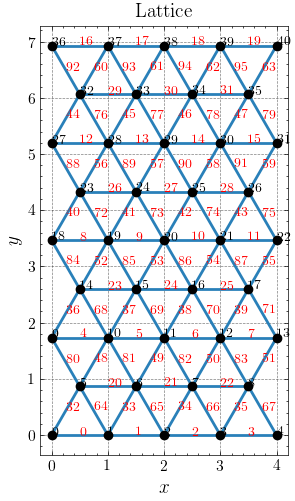

In [4]:
n1 = 4
n2 = 8
spacing = 1.
points = triangular_lattice_points(n1=n1, n2=n2, spacing=spacing)
connectivity = triangular_lattice_connectivity(n1=n1, n2=n2)

n_points = points.shape[0]
n_bonds = connectivity.shape[0]

control_params = ControlParams(
    reference_points=points,
    young=jnp.ones(n_bonds),
    area=jnp.ones(n_bonds),
    thermal_strain=-0.25*jnp.ones(n_bonds),
    damping=0.1*jnp.ones((n_points, 2)),
    masses=1.*jnp.ones((n_points, 2)),
)
lattice = Lattice(
    connectivity=connectivity,
    control_params=control_params
)
plot_lattice(lattice, annotate=True, figsize=(5, 5))


## Response

In [6]:
# Initial conditions
state0 = jnp.array([
    0*lattice.control_params.reference_points,  # Initial displacements
    0*lattice.control_params.reference_points,  # Initial velocities
])
timepoints = jnp.linspace(0, 400, 200)


def control_params_fn(t, control_params: ControlParams):
    # NOTE: This will be replace by the experimental temperature-dependent behavior.
    return control_params._replace(
        young=control_params.young,
        thermal_strain=control_params.thermal_strain*(t/timepoints[-1]),
    )


solve_dynamics, _ = setup_dynamic_solver(
    lattice=lattice,
    control_params_fn=control_params_fn,
    constrained_point_DOF_pairs=jnp.array([[0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [
                                          2, 1], [3, 0], [3, 1], [4, 0], [4, 1]]),
    rigid_bodies_points=[jnp.arange(lattice.n_points-n1-1, lattice.n_points)],  # Last row is a rigid body
)
lattice.solution = solve_dynamics(state0, timepoints, lattice.control_params)

strain_fn = build_strain_fn(lattice.connectivity)


(<Figure size 500x500 with 2 Axes>,
 <Axes: title={'center': 'Final state'}, xlabel='$x$', ylabel='$y$'>)

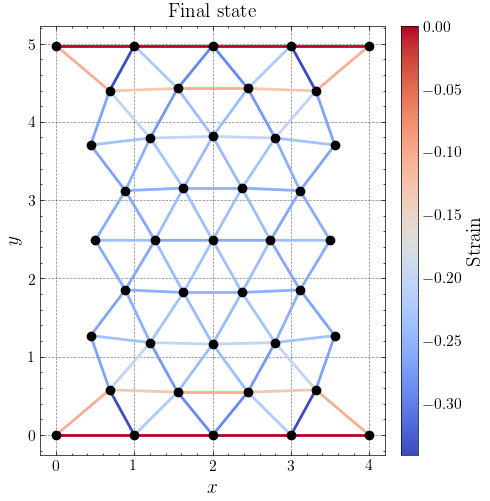

In [7]:
# plot_lattice(lattice, lattice.solution[0, 0], title='Initial state', figsize=(3, 6))
plot_lattice(lattice, lattice.solution[-1, 0], title='Final state', figsize=(5, 5),
             bond_values=strain_fn(lattice.control_params.reference_points, lattice.solution[-1, 0]),
             label='Strain')
